# CPSC-483: Group Project - RUL (Remaining useful lifetime) with batteries

__________________________________________
#### Authors: 
Nils Heimbach

CWID: 885179317

E-Mail: heimbachnils@csu.fullerton.edu
___________________________________________
Jason Duong

CWID: 

E-Mail: xxx@csu.fullerton.edu
_________________________________________

# Table of content: <a class="TOC" id="TOC"></a>

1. [Importing libraries](#1)
2. [Downloading files (only once)](#2)
3. [Data Understanding](#3)
4. [Data Preprocessing](#4)
5. [Data Modeling](#5)
6. [Data Evaluation and Analysis](#6)

External Links: 
- [Written Paper](www.google.de)
- [GitHub](https://github.com/duong-jason/483_ML_BatteryLife)
- [Website Dataset](https://www.batteryarchive.org/list.html?time=0001)

# 1. Importing libraries <a class="importing libraries" id="1"></a>

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from urllib.error import HTTPError

[Click here to go to the top of the chapter](#1)

[Click here for the table of content](#TOC)

# 2. Downloading files <a class="2" id="2"></a>

In [2]:
# Book Code - https://github.com/ageron/handson-ml3/blob/main/01_the_machine_learning_landscape.ipynb
IMAGES_PATH = Path() / 'images'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = IMAGES_PATH / f'{fig_id}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# TODO: verify with partner

def init_path(to=''):
    """Initalizes the path to repository"""
    user = !whoami
    if user == ['jason']:
        path = Path(r'/home/jason/Desktop/483_ML_BatteryLife/') / Path(to.replace("\\", '/'))
    else:
        path = Path(r'C:\Users\heimb\Documents\GitHub\483_ML_BatteryLife/') / Path(to.replace("/", '\\'))
    return path

# Data Consolidation

## Filter/Parse the Data 

In [4]:
def extract_column(dataset, attr, *, pattern=''):
    """
    Returns a list samples of an attribute and
    constrained by some regular expression.
    
    Parameters
    ----------
    dataset -- a csv file
    attr -- an attribute of the dataset 
    regex: the key used to filter specific datapoints (defaults to all)
    """
    df = pd.read_csv(dataset)[attr].squeeze()
    df.replace('/', '-', regex=True, inplace=True)
    return [dp[0] for dp in df.str.findall(fr'^{pattern}.*') if len(dp)]

## Download (Collect/Join), Save, and Load the Data

In [5]:
repos = (r'https://www.batteryarchive.org/data/' + _ + r'_timeseries.csv'
         for _ in extract_column('Input/metadata.csv', 'cell_id', pattern='SNL'))

def load_battery_data(path):
    """
    Downloads the battery data, encoded as a pickle object (*.pkl)
    into the datasets directory.
    
    Data source -- @www.batteryarchive.org
    """
    
    try:
        os.chdir(path)
        data_path = r'Input/battery.pkl'
        if not Path('Input/').is_dir():
            Path('Input').mkdir(parents=True, exist_ok=True)
        if not Path(data_path).is_file():
            df = pd.concat([pd.read_csv(url) for url in repos])
            df.to_pickle(data_path)
            print('Download Complete!')
        return pd.read_pickle(data_path)
    except HTTPError:
        print('Download Failed!')

In [6]:
path = init_path()
battery = load_battery_data(path)

KeyboardInterrupt: 

[Click here to go to the top of the chapter](#1)

[Click here for the table of content](#TOC)

# 3. Data Understanding <a class="3" id="3"></a>

In [12]:
def insights_of_df(df):
    """
    Display of the insights of a data frame such as column names, number
    of null/non-null values, percentage null values, number of unique
    values and data types.

    Parameters
    ----------
        df: pandas.DataFrame.dtypes
            The full dataset

    Returns
    -------
        output: pandas.DataFrame.dtypes
            Dataframe with specified columns
    """
    output = []

    # loop through all columns in the DataFrame
    for col in df.columns:
        nonNull  = len(df) - np.sum(pd.isna(df[col]))
        nullValues = np.sum(pd.isna(df[col]))
        percentNA = nullValues / (nullValues + nonNull)
        unique = df[col].nunique()
        colType = str(df[col].dtype)

        # Append variable to the output list
        output.append([col, nonNull, nullValues, percentNA, unique, colType])

    output = pd.DataFrame(output)
    output.columns = ['colName', 'non-null values', 'null values', 
                      'percentNA', 'unique', 'dtype']
    return output

In [4]:
pickle_path = r"C:\Users\heimb\Documents\GitHub\483_ML_BatteryLife\Input\battery.pkl"
battery = pd.read_pickle(pickle_path)

In [5]:
battery.head()

,Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,2018-02-01 10:02:10.002962,10.002,1.0,0.0,2.940,0.0,0.0,0.0,0.0,15.163,15.375
1,2018-02-01 10:02:20.016433,20.016,1.0,0.0,2.941,0.0,0.0,0.0,0.0,15.148,15.437
2,2018-02-01 10:02:30.031429,30.031,1.0,0.0,2.941,0.0,0.0,0.0,0.0,15.087,15.375
3,2018-02-01 10:02:40.046426,40.046,1.0,0.0,2.941,0.0,0.0,0.0,0.0,15.240,15.375
4,2018-02-01 10:02:50.061462,50.061,1.0,0.0,2.941,0.0,0.0,0.0,0.0,15.087,15.375


In [7]:
battery.shape

(23888882, 11)

In [8]:
battery.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23888882 entries, 0 to 80104
Data columns (total 11 columns):
 #   Column                       Non-Null Count     Dtype  
---  ------                       --------------     -----  
 0   Date_Time                    23888882 non-null  object 
 1   Test_Time (s)                23888882 non-null  float64
 2   Cycle_Index                  23888882 non-null  float64
 3   Current (A)                  23888882 non-null  float64
 4   Voltage (V)                  23888882 non-null  float64
 5   Charge_Capacity (Ah)         23888882 non-null  float64
 6   Discharge_Capacity (Ah)      23888882 non-null  float64
 7   Charge_Energy (Wh)           23888882 non-null  float64
 8   Discharge_Energy (Wh)        23888882 non-null  float64
 9   Environment_Temperature (C)  23365199 non-null  float64
 10  Cell_Temperature (C)         23365199 non-null  float64
dtypes: float64(10), object(1)
memory usage: 2.1+ GB


In [13]:
insights_of_df(battery)

,colName,non-null values,null values,percentNA,unique,dtype
0,Test_Time (s),23888882,0,0.000000,23874887,float64
1,Cycle_Index,23888882,0,0.000000,19175,float64
2,Current (A),23888882,0,0.000000,2039,float64
3,Voltage (V),23888882,0,0.000000,2333,float64
4,Charge_Capacity (Ah),23888882,0,0.000000,19275,float64
5,Discharge_Capacity (Ah),23888882,0,0.000000,9734,float64
6,Charge_Energy (Wh),23888882,0,0.000000,63812,float64
7,Discharge_Energy (Wh),23888882,0,0.000000,31488,float64
8,Environment_Temperature (C),23365199,523683,0.021922,10688,float64
9,Cell_Temperature (C),23365199,523683,0.021922,39204,float64


In [10]:
if 'Date_Time' in battery.columns:
    battery = battery.drop(['Date_Time'], axis=1)

In [ ]:
# replaycing whitespaces, and nan-values and doing data understanding again
battery.replace(' ', np.NaN, inplace=True)
battery['Environment_Temperature (C)'].replace(np.NaN, battery['Environment_Temperature (C)'].mean(), inplace=True)
battery['Cell_Temperature (C)'].replace(np.NaN, battery['Cell_Temperature (C)'].mean(), inplace=True)

In [ ]:
battery.info(show_counts=True)

In [15]:
battery.head()

,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
0,10.002,1.0,0.0,2.940,0.0,0.0,0.0,0.0,15.163,15.375
1,20.016,1.0,0.0,2.941,0.0,0.0,0.0,0.0,15.148,15.437
2,30.031,1.0,0.0,2.941,0.0,0.0,0.0,0.0,15.087,15.375
3,40.046,1.0,0.0,2.941,0.0,0.0,0.0,0.0,15.240,15.375
4,50.061,1.0,0.0,2.941,0.0,0.0,0.0,0.0,15.087,15.375


In [16]:
battery.describe()

,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
count,2.388888e+07,2.388888e+07,2.388888e+07,2.388888e+07,2.388888e+07,2.388888e+07,2.388888e+07,2.388888e+07,2.388888e+07,2.388888e+07
mean,1.613473e+07,2.841530e+03,-1.981644e-01,3.446082e+00,9.805721e-01,3.515892e-01,3.558338e+00,1.218359e+00,2.491242e+01,2.591522e+01
std,1.366815e+07,3.178384e+03,1.398625e+00,3.230248e-01,1.092508e+00,7.203539e-01,3.933567e+00,2.461379e+00,4.885589e+00,4.789597e+00
min,2.100000e-02,1.000000e+00,-9.998000e+00,-4.646000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.234700e+01,5.605000e+00
25%,4.554111e+06,5.210000e+02,-1.499000e+00,3.280000e+00,4.500000e-01,0.000000e+00,1.525000e+00,0.000000e+00,2.444300e+01,2.449400e+01
50%,1.292059e+07,1.853000e+03,1.000000e-03,3.386000e+00,6.410000e-01,0.000000e+00,2.260000e+00,0.000000e+00,2.477200e+01,2.506100e+01
75%,2.519087e+07,3.684000e+03,5.490000e-01,3.614000e+00,1.036000e+00,4.400000e-01,3.503000e+00,1.513000e+00,2.505600e+01,2.630100e+01
max,6.618272e+07,1.917500e+04,9.999000e+00,9.983000e+00,1.927600e+01,9.735000e+00,6.382100e+01,3.149800e+01,3.729300e+01,5.536100e+01


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=10)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

battery.hist(bins=50, figsize=(10, 10))
plt.show()

In [18]:
insights_of_df(battery)

,colName,non-null values,null values,percentNA,unique,dtype
0,Test_Time (s),23888882,0,0.0,23874887,float64
1,Cycle_Index,23888882,0,0.0,19175,float64
2,Current (A),23888882,0,0.0,2039,float64
3,Voltage (V),23888882,0,0.0,2333,float64
4,Charge_Capacity (Ah),23888882,0,0.0,19275,float64
5,Discharge_Capacity (Ah),23888882,0,0.0,9734,float64
6,Charge_Energy (Wh),23888882,0,0.0,63812,float64
7,Discharge_Energy (Wh),23888882,0,0.0,31488,float64
8,Environment_Temperature (C),23888882,0,0.0,10689,float64
9,Cell_Temperature (C),23888882,0,0.0,39205,float64


[Click here to go to the top of the chapter](#1)

[Click here for the table of content](#TOC)

# 4. Data Preprocessing <a class="4" id="4"></a>

## Feature Selection - Principal Component Analysis (PCA)

In [19]:
# Reduce number of instances
small_battery = battery.groupby(battery['Cycle_Index']).mean()

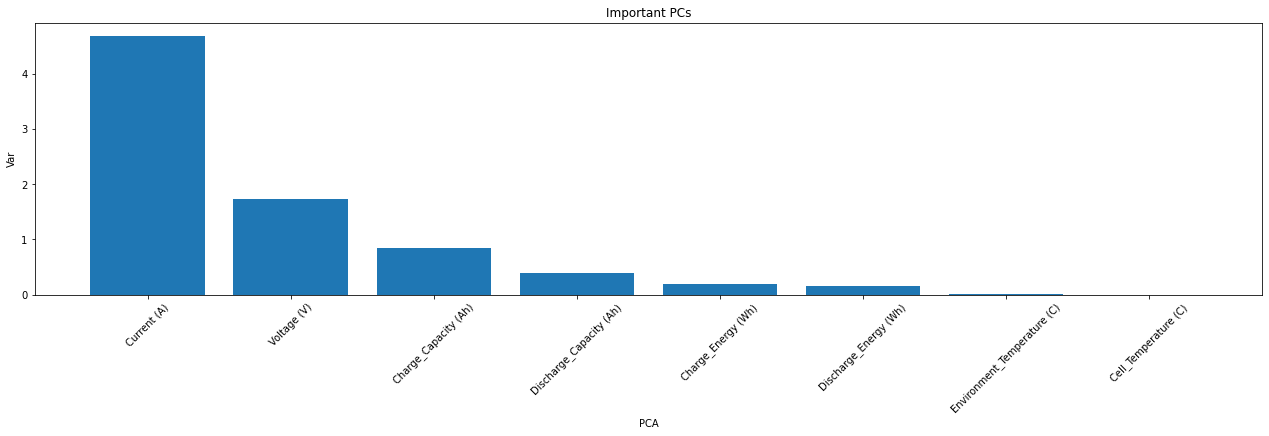

In [21]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = small_battery.iloc[:, 1:]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X)

# Plot a bar chart describing the variance of each feature
features = range(pca.n_components_)
features2 = X.columns

# Define bar chart size
_ = plt.figure(figsize=(22, 5))

# Define actual bar chart
_ = plt.bar(features2, pca.explained_variance_)

# Labels, Titles und Ticks of the bar chart 
_ = plt.xlabel('PCA')
_ = plt.ylabel('Var')
_ = plt.xticks(features2, rotation=45)
_ = plt.title("Important PCs")

# Display the bar chart
plt.show()

In [22]:
# Drop irrelevant features from PCA
small_battery = small_battery.drop(
    ['Environment_Temperature (C)', 'Cell_Temperature (C)'], axis=1)

In [23]:
# Save reduced dataset to disk
path = init_path(to='Output/small_battery.pkl')
small_battery.to_pickle(path)
small_battery = pd.read_pickle(path)

In [24]:
small_battery.head()

,Test_Time (s),Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
Cycle_Index,,,,,,,
1.0,7934.390433,-0.097194,3.496759,1.671898,0.647405,6.278663,2.343179
2.0,23676.607595,-0.062176,3.484337,1.699177,0.630862,6.334384,2.283184
3.0,39528.513582,-0.064466,3.485332,1.699607,0.632667,6.337541,2.291588
4.0,56647.632293,-0.029947,3.618597,2.475763,1.171745,9.361761,4.036673
5.0,75399.874005,-0.036432,3.566395,1.454018,0.414557,5.421763,1.464777


In [25]:
small_battery.describe()

,Test_Time (s),Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
count,1.917500e+04,19175.000000,19175.000000,19175.000000,19175.000000,19175.000000,19175.000000
mean,3.066868e+07,-0.310247,3.379044,0.408434,0.143121,1.468028,0.492227
std,1.167348e+07,0.337714,0.082780,0.342212,0.127923,1.268894,0.455077
min,7.934390e+03,-0.997238,2.682210,0.000000,0.000000,0.000000,0.000000
25%,2.540319e+07,-0.627955,3.298308,0.085692,0.029692,0.287269,0.097308
50%,2.956835e+07,-0.155833,3.368514,0.458573,0.167645,1.662050,0.562804
75%,3.571093e+07,-0.002231,3.446318,0.516880,0.193618,1.866243,0.668108
max,5.764031e+07,0.131182,4.056593,9.819423,5.226918,32.527234,16.916578


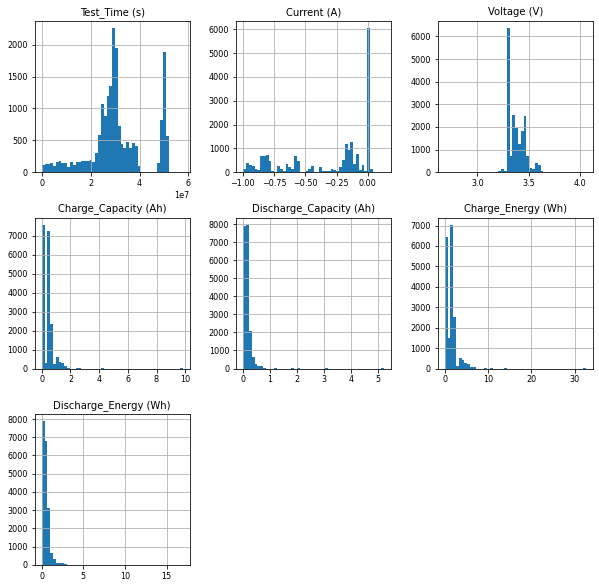

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=10)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

small_battery.hist(bins=50, figsize=(10, 10))
plt.show()

## Correlation Matrix

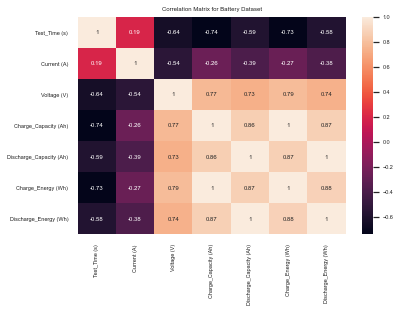

In [27]:
sns.set(font_scale=0.5)
corr_matrix = small_battery.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix for Battery Dataset')
plt.show()

[Click here to go to the top of the chapter](#1)

[Click here for the table of content](#TOC)

# 5. Data Modeling <a class="5" id="5"></a>

In [28]:
# Add RUL feature
small_battery['RUL'] = 19175 - small_battery.index
small_battery

,Test_Time (s),Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),RUL
Cycle_Index,,,,,,,,
1.0,7.934390e+03,-0.097194,3.496759,1.671898,0.647405,6.278663,2.343179,19174.0
2.0,2.367661e+04,-0.062176,3.484337,1.699177,0.630862,6.334384,2.283184,19173.0
3.0,3.952851e+04,-0.064466,3.485332,1.699607,0.632667,6.337541,2.291588,19172.0
4.0,5.664763e+04,-0.029947,3.618597,2.475763,1.171745,9.361761,4.036673,19171.0
5.0,7.539987e+04,-0.036432,3.566395,1.454018,0.414557,5.421763,1.464777,19170.0
...,...,...,...,...,...,...,...,...
19171.0,5.077758e+07,-0.001778,3.297111,0.049333,0.018444,0.167111,0.060444,4.0
19172.0,5.078447e+07,-0.171828,3.226446,0.488071,0.356586,1.658896,1.160421,3.0
19173.0,5.079782e+07,-0.028330,3.231563,0.756450,0.287493,2.528943,0.935721,2.0


In [29]:
small_battery

,Test_Time (s),Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),RUL
Cycle_Index,,,,,,,,
1.0,7.934390e+03,-0.097194,3.496759,1.671898,0.647405,6.278663,2.343179,19174.0
2.0,2.367661e+04,-0.062176,3.484337,1.699177,0.630862,6.334384,2.283184,19173.0
3.0,3.952851e+04,-0.064466,3.485332,1.699607,0.632667,6.337541,2.291588,19172.0
4.0,5.664763e+04,-0.029947,3.618597,2.475763,1.171745,9.361761,4.036673,19171.0
5.0,7.539987e+04,-0.036432,3.566395,1.454018,0.414557,5.421763,1.464777,19170.0
...,...,...,...,...,...,...,...,...
19171.0,5.077758e+07,-0.001778,3.297111,0.049333,0.018444,0.167111,0.060444,4.0
19172.0,5.078447e+07,-0.171828,3.226446,0.488071,0.356586,1.658896,1.160421,3.0
19173.0,5.079782e+07,-0.028330,3.231563,0.756450,0.287493,2.528943,0.935721,2.0


## Train-Test Split

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_full, y_full = battery.iloc[:, :-1], battery.iloc[:, -1]
X_full_train, X_full_test, y_full_train, y_full_test = \
    train_test_split(X_full, y_full, test_size=0.33, random_state=42)

In [32]:
X_red, y_red = small_battery.iloc[:, :-1], small_battery.iloc[:, -1]
X_red_train, X_red_test, y_red_train, y_red_test = \
    train_test_split(X_red, y_red, test_size=0.33, random_state=42)

## Model 1: Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

### Full Dataset

In [52]:
lr_full = LinearRegression()
lr_full.fit(X_full_train, y_full_train)
lr_full.score(X_full_train, y_full_train)

0.8409660117091309

In [53]:
lr_full_pred = lr_full.predict(X_full_test)
lr_full.score(X_full_test, y_full_test)

0.8412306901747577

### Reduced Dataset

In [54]:
lr_red = LinearRegression()
lr_red.fit(X_red_train, y_red_train)
lr_red.score(X_red_train, y_red_train)

0.9158523759626975

In [55]:
lr_red_pred = lr_red.predict(X_red_test)
lr_red.score(X_red_test, y_red_test)

0.8558235187606312

In [56]:
pickle.dump(lr_full, open('Output/lr_full.model', 'wb'))
pickle.dump(lr_red, open('Output/lr_reduced.model', 'wb'))

# load the model from disk
lr_red = pickle.load(open('Output/lr_reduced.model', 'rb'))
result = lr_red.score(X_red_test, y_red_test)
print(result)

0.8558235187606312


## Model 2: Huber Regression

In [57]:
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor()
huber.fit(X_red_train, y_red_train)
huber.score(X_red_train, y_red_train)

-1.3145318534673547

In [58]:
huber_pred = huber.predict(X_red_test)
huber.score(X_red_test, y_red_test)

-1.3102903376707866

In [59]:
pickle.dump(huber, open('Output/huber.model', 'wb'))

# load the model from disk
huber = pickle.load(open('Output/huber.model', 'rb'))
result = huber.score(X_red_test, y_red_test)
print(result)

-1.3102903376707866


## Model 3: Theil Sen Regression

In [60]:
from sklearn.linear_model import TheilSenRegressor

theilsen = TheilSenRegressor(random_state=42)
theilsen.fit(X_red_train, y_red_train)
theilsen_pred = theilsen.predict(X_red_test)
theilsen.score(X_red_train, y_red_train)

0.8133716500491567

In [61]:
pickle.dump(huber, open('Output/theilsen.model', 'wb'))

# load the model from disk
theilsen = pickle.load(open('Output/theilsen.model', 'rb'))
result = theilsen.score(X_red_test, y_red_test)
print(result)

-1.3102903376707866


## Model 4: RANSAC Regression

In [62]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(random_state=42)
ransac.fit(X_red_train, y_red_train)
ransac.score(X_red_train, y_red_train)

0.7961699000070771

In [63]:
pickle.dump(huber, open('Output/ransac.model', 'wb'))

# load the model from disk
ransac = pickle.load(open('Output/ransac.model', 'rb'))
result = ransac.score(X_red_test, y_red_test)
print(result)

-1.3102903376707866


## Model 5: Ensemble Learning

In [64]:
from sklearn.ensemble import VotingRegressor

model_1 = LinearRegression()
model_2 = HuberRegressor()
model_3 = TheilSenRegressor(random_state=42)
model_4 = RANSACRegressor(random_state=42)


vote_reg = VotingRegressor([('linear', model_1),
                            ('huber', model_2),
                            ('theilsen', model_3),
                            ('ransac', model_4)])
vote_reg.fit(X_red_train, y_red_train)
vote_reg_pred = vote_reg.predict(X_red_test)
vote_reg.score(X_red_test, y_red_test)

0.7937623127635202

In [65]:
pickle.dump(vote_reg, open('Output/vote_reg.model', 'wb'))

# load the model from disk
vote_reg = pickle.load(open('Output/vote_reg.model', 'rb'))
result = vote_reg.score(X_red_test, y_red_test)
print(result)

0.7937623127635202


# 6. Data Evaluation and Analysis <a class="6" id="6"></a>

In [66]:
def regression_metrics(y_true, y_pred):
    """
    Calculate the regression metrics such as mean absolute error, mean
    squared error, root mean squared error, mean absolute percentage
    error and R-squared.

    Parameters
    ----------
        y_true: pandas.Series
            The true values of the target variable
        y_pred: pandas.Series
            The predicted values of the target variable

    Returns
    -------
        output: 4 metrics: mae, mse, rmse, r2
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np

    # Calculate the metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    #mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # return the metrics
    return mae, mse, rmse, r2

In [68]:
pred_dict = {"LinRe":lr_red_pred, "HuberReg":huber_pred, "TheilsenReg":theilsen_pred, "Ensemble":vote_reg_pred}

df_scores = pd.DataFrame(columns=["Name","R2", "MSE", "RMSE", "MAE"])

for key, value in pred_dict.items(): 
    # calculating regression metrics
    mae, mse, rmse, r2 = regression_metrics(y_red_test, value)
    # adding model and metrics to df
    new_dict = {"Name":key+"_train","R2":r2, "MSE":mse, "RMSE":rmse, "MAE":mae}
    df_scores = df_scores.append(new_dict, ignore_index=True)
    
df_scores
    

<ipython-input-68-7dc32953f2dc>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(new_dict, ignore_index=True)
<ipython-input-68-7dc32953f2dc>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(new_dict, ignore_index=True)
<ipython-input-68-7dc32953f2dc>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(new_dict, ignore_index=True)
<ipython-input-68-7dc32953f2dc>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(new_dict, ignore_index=True)


,Name,R2,MSE,RMSE,MAE
0,LinRe_train,0.855824,4370132.529289,2090.486194,1093.172082
1,HuberReg_train,-1.31029,70027197.709138,8368.225481,6841.906835
2,TheilsenReg_train,0.589318,12448183.925698,3528.198397,995.088816
3,Ensemble_train,0.793762,6251269.402678,2500.253868,1884.356792


In [2]:
import statsmodels.api as sm

result = sm.OLS(y_red_train, X_red_train).fit()
print(result.summary())

NameError: name 'y_red_train' is not defined